# Натянуть сову на линейное пространство

Создайте эмбеддинги слов и визуализируйте векторные операции над ними: сложение, вычитание, взятие ближайшего, дальнейшего и прочее. Сравните качество представлений gensim и BERT с точки зрения операций над словами, докажите примерами.

Для создания эмбеддингов с gensim обучите модель на нормализованных текстовых данных. Данные найдите на kaggle или выберите один из предложенных датасетов. Для создания эмбеддингов с BERT используйте предобученные модели.

Предлагаемые датасеты:
 - [sentiment твитов про ковид](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)
 - [Amazon product reviews](https://www.kaggle.com/kashnitsky/hierarchical-text-classification)
 - [Отзывы интернет-магазина](https://www.kaggle.com/shymammoth/shopee-reviews)
 - [Тексты статей конференции NIPS](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv)

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('shopee_reviews.csv')

c:\python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502575 entries, 0 to 1502574
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1502575 non-null  object
 1   text    1502575 non-null  object
dtypes: object(2)
memory usage: 22.9+ MB


In [4]:
df[10:20]

,label,text
10,5,Fast. Great
11,5,"I've tried it, and it works as advertised"
12,5,Hub uses it. Muscle growth on the upper arm.
13,5,Well received. Fast delivery and yet to replac...
14,5,Product received. Packaging damage but the uni...
15,5,Good..
16,5,"box was a little beat up and had a smell, but ..."
17,4,"Fast delivery, however the product casing was ..."
18,5,"Fast delivery, prompt response. The material i..."
19,5,Product received was exactly the the same as p...


In [5]:
reviews = df['text']
reviews.shape

(1502575,)

#### Предобработка текста

In [6]:
from typing import List
from collections import Counter
from itertools import chain

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

In [7]:
vocab = build_vocab(reviews)
print(len(vocab))
# слова разного регистра
list(vocab.items())[:30]

342808


[('Looks', 23179),
 ('ok.', 15341),
 ('Not', 32351),
 ('like', 63581),
 ('so', 102367),
 ('durable.', 1222),
 ('Will', 84734),
 ('hv', 1257),
 ('to', 473417),
 ('use', 42793),
 ('a', 279962),
 ('while', 11381),
 ('recommend', 19793),
 ('others', 2664),
 ('of', 146949),
 ('its', 37505),
 ('worth.', 437),
 ('Tried,', 96),
 ('the', 715038),
 ('current', 5037),
 ('can', 48956),
 ('be', 63104),
 ('very', 154380),
 ('powerful', 684),
 ('depending', 160),
 ('on', 139660),
 ('setting,', 28),
 ('i', 54622),
 ("don't", 4288),
 ('dare', 159)]

In [8]:
!pip install nltk

In [10]:
# natural language toolkit
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

eng_stopwords = stopwords.words('english')
print(len(eng_stopwords))
eng_stopwords[:30]

179


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself']

In [15]:
# удалим стоп-слова
eng_stopwords = set(eng_stopwords)

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    is_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    return text


reviews = [preprocess_text(review) for review in reviews]
vocab = build_vocab(texts)
        
print(len(vocab))
# уже лучше. Но есть стоп-слова самого корпуса
vocab.most_common(30)

342808


[('the', 715038),
 ('and', 647294),
 ('to', 473417),
 ('is', 451407),
 ('good', 414298),
 ('in', 411443),
 ('for', 310487),
 ('it', 308621),
 ('a', 279962),
 ('but', 222233),
 ('received', 209135),
 ('as', 191776),
 ('with', 191289),
 ('was', 181966),
 ('delivery', 169304),
 ('I', 161974),
 ('my', 161371),
 ('very', 154380),
 ('fast', 147896),
 ('of', 146949),
 ('not', 143196),
 ('Item', 143161),
 ('Received', 142530),
 ('on', 139660),
 ('Fast', 130963),
 ('well', 122761),
 ('Good', 116713),
 ('this', 105019),
 ('quality', 105010),
 ('condition.', 104781)]

In [16]:
# Посмотрим сколько уникальных слов

def merge_reviews(reviews: list[str]) -> str:
    return ' '.join(reviews)
    
    
unique_words =list(set(merge_reviews(reviews).split(' ')))
len(unique_words)

155591

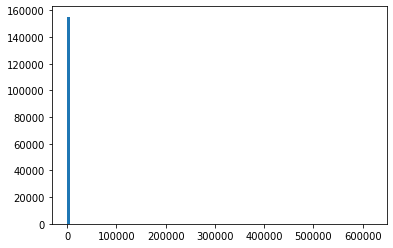

In [17]:
import matplotlib.pyplot as plt
# Оставим частые слова

from collections import Counter

counts = Counter(merge_reviews(reviews).split(' '))
freqs = list(counts.values())
plt.hist(freqs, bins=100)
plt.show()

In [3]:
import numpy as np

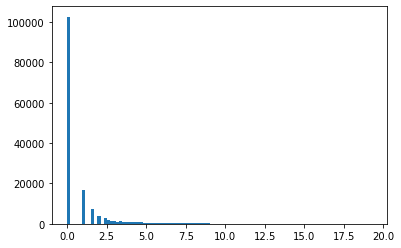

In [18]:

plt.hist(np.log2(freqs), bins=100)
plt.show()

###nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() Применим лемматизацию.

In [36]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
def lemmatizing(text):
    text = ' '.join(list(map(lemmatizer.lemmatize, text.split())))
    return text

In [ ]:
from tqdm import tqdm
reviews_lem = [lemmatizing(review) for review in tqdm(reviews, leave=True, position=0)]

In [ ]:
reviews_lem[:10]

In [40]:
type(reviews_lem)

list

In [2]:
import numpy as np

In [41]:

data = np.array(reviews_lem)
np.savez("reviews_lem", data)


In [3]:
data = np.load('reviews_lem.npz')
reviews_lem = data['arr_0'].tolist()

### gensim

In [43]:
# Для простоты реализации воспользуемся библиотекой gensim

from gensim.models import Word2Vec

sentences = [review.split() for review in reviews_lem]
model = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=15, 
                 min_count=1
                 )
print('размерность векторов слов в модели:', model.wv.vectors.shape)

размерность векторов слов в модели: (150387, 100)


In [44]:
model.save('tmp')

In [4]:
import gensim
new_model = gensim.models.Word2Vec.load('tmp')

In [45]:
import umap
# Спроецируем в 2d пространство

points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])

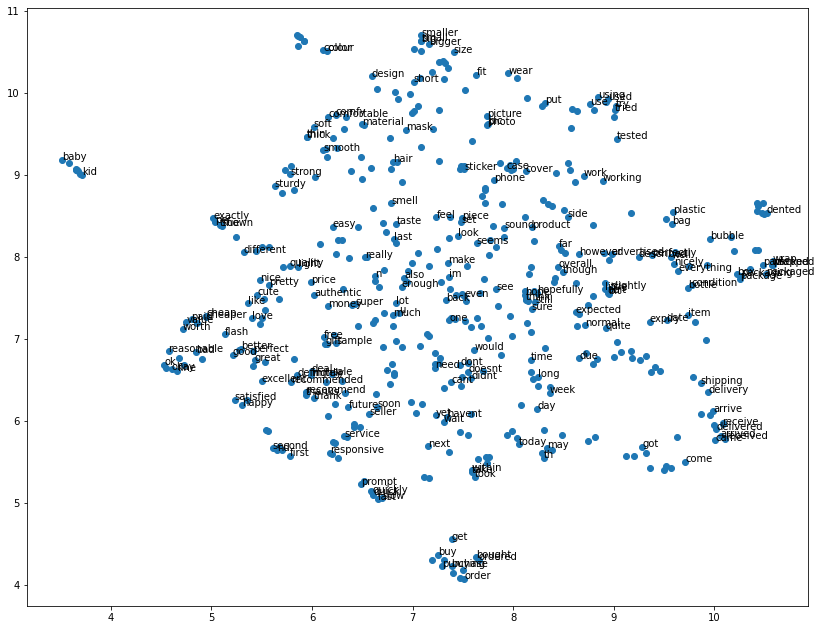

In [46]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model.wv.index_to_key[:200]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [ ]:
type(model)

In [ ]:
# dir(model.wv)

In [ ]:
type(model.wv.index_to_key)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# log embeddings
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer.add_embedding(model.wv.vectors, metadata=model.wv.index_to_key)
writer.close()

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=runs --bind_all

### BERT

In [ ]:
!pip install transformers

In [12]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
# Load pre-trained model (weights)
model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# Tests

## gensim

In [90]:
#dir(model.wv)

In [79]:
def get_similar_gensim(w, topn=5):
    return model.wv.most_similar(w, topn=topn)

In [80]:
def sum_words_gensim(w1, w2):
    w1 = lemmatizing(w1)
    w2 = lemmatizing(w2)
    return model.wv.get_vector(w1) + model.wv.get_vector(w2)

In [81]:
def sub_words_gensim(w1, w2, topn=5):
    w1 = lemmatizing(w1)
    w2 = lemmatizing(w2)
    return model.wv.get_vector(w1) - model.wv.get_vector(w2)

In [65]:
get_similar_gensim(sum_words_gensim('fast', 'delivery'))

[('delivery', 0.6124367713928223),
 ('fast', 0.6058216691017151),
 ('shipping', 0.5149460434913635),
 ('considered', 0.49853014945983887),
 ('efficient', 0.49817416071891785)]

In [66]:
get_similar_gensim(sum_words_gensim('received', 'exactly'))

[('exactly', 0.78537917137146),
 ('received', 0.7114383578300476),
 ('recieved', 0.6714805960655212),
 ('arrived', 0.6622987985610962),
 ('came', 0.6115758419036865)]

In [67]:
get_similar_gensim(sum_words_gensim('small', 'exactly'))

[('small', 0.7731467485427856),
 ('exactly', 0.7555182576179504),
 ('big', 0.6538877487182617),
 ('tiny', 0.6452298760414124),
 ('smaller', 0.6305045485496521)]

In [68]:
get_similar_gensim(sum_words_gensim('expensive', 'kid'))

[('expensive', 0.7258939146995544),
 ('kid', 0.7087664604187012),
 ('child', 0.6453214287757874),
 ('boy', 0.6183884143829346),
 ('girl', 0.6158367991447449)]

In [71]:
get_similar_gensim(sum_words_gensim('male', 'kid'))

[('kid', 0.9030582904815674),
 ('child', 0.8681529760360718),
 ('boy', 0.7971563935279846),
 ('girl', 0.7898962497711182),
 ('toddler', 0.7737468481063843)]

In [75]:
get_similar_gensim(sub_words_gensim('boy', 'kid'))

[('hanbok', 0.4610828757286072),
 ('sacramento', 0.43584465980529785),
 ('bodysuit', 0.413754940032959),
 ('troy', 0.41225942969322205),
 ('zigzag', 0.41130807995796204)]

In [76]:
get_similar_gensim(sub_words_gensim('boy', 'kid'))

[('hanbok', 0.4610828757286072),
 ('sacramento', 0.43584465980529785),
 ('bodysuit', 0.413754940032959),
 ('troy', 0.41225942969322205),
 ('zigzag', 0.41130807995796204)]

In [77]:
get_similar_gensim(sub_words_gensim('wonderful', 'fast'))

[('wonderful', 0.5530006885528564),
 ('deliverygreat', 0.37149471044540405),
 ('lehs', 0.36560413241386414),
 ('admire', 0.3623937964439392),
 ('hapeestore', 0.35470083355903625)]

In [82]:
get_similar_gensim('fast')

[('quick', 0.8987053632736206),
 ('speedy', 0.8405648469924927),
 ('prompt', 0.7896718382835388),
 ('fastthe', 0.7099915742874146),
 ('swift', 0.6930599808692932)]

In [83]:
get_similar_gensim('boy')

[('girl', 0.9461214542388916),
 ('son', 0.9209843277931213),
 ('daughter', 0.9176813364028931),
 ('gal', 0.9126652479171753),
 ('kid', 0.8462045192718506)]

In [84]:
get_similar_gensim('disappoint')

[('disappoints', 0.8548948168754578),
 ('dissapoint', 0.7984794974327087),
 ('fails', 0.7210639119148254),
 ('fail', 0.697834849357605),
 ('worksplease', 0.6574950218200684)]

In [87]:
model.wv.most_similar(negative = 'good', topn=5)

[('conditoon', 0.42834076285362244),
 ('thkxssss', 0.4157364070415497),
 ('eeeetehwoncaslehhh', 0.4123115837574005),
 ('儿子很开心', 0.3960675001144409),
 ('conditions', 0.39594870805740356)]

In [88]:
model.wv.most_similar(negative = 'fast', topn=5)

[('upyeah', 0.3697245121002197),
 ('deliverywill', 0.3693915605545044),
 ('deivery', 0.3682378828525543),
 ('delivety', 0.36283358931541443),
 ('delievery', 0.3573198914527893)]

In [89]:
model.wv.most_similar(negative = 'cheap', topn=5)

[('informed', 0.39557695388793945),
 ('conditionexpected', 0.3920026421546936),
 ('ordernicely', 0.3862084448337555),
 ('alhamdulillahreceived', 0.385600209236145),
 ('iftar', 0.3804769814014435)]

## Bert

In [19]:
# incapsulate to function

def get_word_embedding(word: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    embeddings = outputs[2]
    #print(type(outputs))
    last_layer_embs = embeddings[-1]
    sentense_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    
    return sentense_embedding

In [20]:
from itertools import chain
from tqdm import tqdm

In [21]:
words = list(chain.from_iterable([text.split() for text in reviews_lem]))

In [22]:
words = list(set(words))

In [23]:
len(words)

150387

In [24]:
texts_embs = []

for text in tqdm(words[:1000], leave=True, position=0):
    ##print(text
    emb = get_word_embedding(text)
    texts_embs.append(emb);

100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


In [38]:
texts_embs = torch.stack(texts_embs)

texts_embs.size()

torch.Size([1000, 768])

In [25]:
def sum_words_bert(w1, w2):
    w1 = lemmatizing(w1)
    w2 = lemmatizing(w2)
    return texts_embs[words.index(w1)] + texts_embs[words.index(w2)]

In [57]:
def sub_words_bert(w1, w2):
    w1 = lemmatizing(w1)
    w2 = lemmatizing(w2)
    return texts_embs[words.index(w1)] - texts_embs[words.index(w2)]

In [50]:
def get_similar_bert(text_emb, topn=5):
    li = torch.nn.functional.cosine_similarity(text_emb, texts_embs).tolist();
    inds = sorted(range(len(li)), key=lambda k: li[k])[:topn];
    return [words[ind] for ind in inds];

In [64]:
def get_not_similar_bert(text_emb, topn=5):
    li = torch.nn.functional.cosine_similarity(text_emb, texts_embs).tolist();
    inds = sorted(range(len(li)), key=lambda k: li[k], reverse=True)[:topn];
    return [words[ind] for ind in inds];

In [32]:
words[810:820]

['mefor',
 'cheatedwont',
 'sook',
 'goodrocking',
 'gudehh',
 'packagingcorrect',
 'newwell',
 'cloudthe',
 'greatsuperbcoolingi',
 'enforce']

In [59]:
get_similar_bert(sum_words_bert('fridaysound', 'sook'))

['sook', 'vanfast', 'funnyleft', 'soooon', 'knowthank']

In [60]:
get_similar_bert(sub_words_bert('fridaysound', 'sook'))

['sook', 'vanfast', 'funnyleft', 'soooon', 'knowthank']

In [63]:
get_similar_bert(texts_embs[words.index('sook')])

['xhp', 'desugn', 'receptor', 'dominate', 'cabin']

In [65]:
get_not_similar_bert(texts_embs[words.index('sook')])

['sook', 'knowthank', 'soooon', 'lighti', 'yrold']

# Projector

Из прошлого задания вы выяснили наиболее хорошую для представления связей между словами модель. Спроецируйте ~2-3 тысячи наиболее популярных слов из выбранного корпуса в tensorflow projector.

Сказать тружно. bert я не смог нормально рассмотреть. Пусть лечше ведет себя gensim.

In [ ]:
Сделано выше кек.